In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from persim import plot_diagrams

In [2]:
from astropology.constants import PASSBANDS, CLASSES
from astropology.plasticc import lcs_from_plasticc

In [4]:
# Load data
data_directory = "/home/edgar/astropology/data/"
band = "g_band"
norm = "no"
b_dist = np.load(
    f"{data_directory}/bottleneck_series_7848_norm_{norm}_{band}_mask_negative.npy",
    mmap_mode="r"
)
w_dist = np.load(
    f"{data_directory}/wasserstein_series_7848_norm_{norm}_{band}_mask_negative.npy",
    mmap_mode="r"
)

# load map from idx to objectid
idx_id_b_dist = np.load(
    f"{data_directory}/objid_bottleneck_"
    f"series_7848_norm_{norm}_{band}_mask_negative.npy",
    mmap_mode="r",
    
).astype(int)

idx_id_w_dist = np.load(
    f"{data_directory}/objid_wasserstein_"
    f"series_7848_norm_{norm}_{band}_mask_negative.npy",
    mmap_mode="r"
).astype(int)

n_series = w_dist.shape[0]

In [5]:
lcs = pd.read_csv(
    f"{data_directory}/plasticc_train_lightcurves.csv.gz",
)
meta_data = pd.read_csv(
    f"{data_directory}/plasticc_train_metadata.csv.gz",
    index_col="object_id"
)

# Explore distribution of mean distance

In [6]:
b_score = np.nanmean(b_dist, axis=1)
b_score *= 1/np.nanmax(b_score)

w_score = np.nanmean(w_dist, axis=1)
w_score *= 1/np.nanmax(w_score)

In [7]:
quantiles = [0.25, 0.5, 0.75, 0.8, 0.9, 0.95, 0.99]

Wasserstein distance

In [8]:
q_w_score = np.quantile(w_score, q=quantiles)
q_b_score = np.quantile(b_score, q=quantiles)

for idx, q in enumerate(quantiles):

    print(
        f"wdist: {int(q*100)}% -> {q_w_score[idx]:.4e} \t"
        f"bdist: {int(q*100)}% -> {q_b_score[idx]:.4e}"
    )

wdist: 25% -> 5.1218e-03 	bdist: 25% -> 2.8048e-03
wdist: 50% -> 5.2067e-03 	bdist: 50% -> 2.8417e-03
wdist: 75% -> 5.5113e-03 	bdist: 75% -> 3.1758e-03
wdist: 80% -> 5.7182e-03 	bdist: 80% -> 3.4036e-03
wdist: 90% -> 7.2397e-03 	bdist: 90% -> 4.7121e-03
wdist: 95% -> 1.3320e-02 	bdist: 95% -> 1.0866e-02
wdist: 99% -> 1.1743e-01 	bdist: 99% -> 6.4757e-02


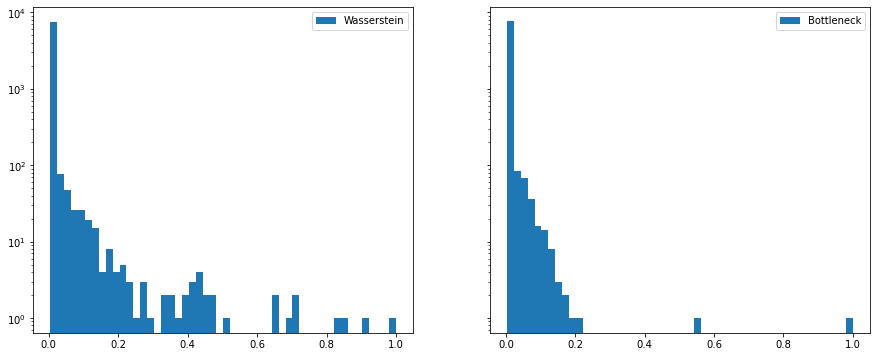

In [9]:
fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(15, 6))

max = 1e-0

_ = axs[0].hist(
    w_score, bins=50, range=(np.nanmin(w_score), max),
    label="Wasserstein",
)
_ = axs[1].hist(
    b_score, bins=50, range=(np.nanmin(b_score), max),
    label="Bottleneck",
    # color="red", alpha=0.5,
)

for ax in axs:
    # ax.set_xscale("log")
    ax.ticklabel_format(axis="x", style="sci", scilimits=(-4, 0))
    ax.set_yscale("log")
    ax.legend()

In [10]:
CLASSES

{90: 'SNIa',
 67: 'SNIa-91bg',
 52: 'SNIax',
 42: 'SNII',
 62: 'SNIbc',
 95: 'SLSN-I',
 15: 'TDE',
 64: 'KN',
 88: 'AGN',
 92: 'RRL',
 65: 'M-dwarf',
 16: 'EB',
 53: 'Mira',
 6: 'µLens-Single',
 991: 'µLens-Binary',
 992: 'ILOT',
 993: 'CaRT',
 994: 'PISN',
 995: 'µLens-String'}

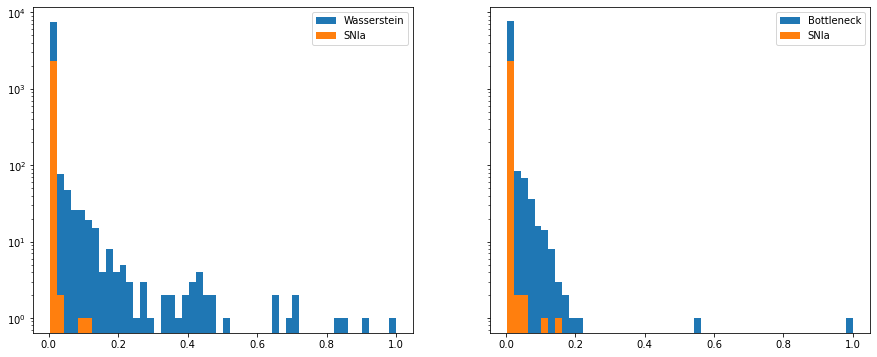

In [11]:
fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(15, 6))
n_bins = 50
max = 1e-0

_ = axs[0].hist(
    w_score, bins=n_bins, range=(np.nanmin(w_score), max),
    label="Wasserstein",
)


_ = axs[1].hist(
    b_score, bins=n_bins, range=(np.nanmin(b_score), max),
    label="Bottleneck",
    # color="red", alpha=0.5,
)

for target in [90]:

    w_score_target = score_of_class(
        target, w_score, meta_data, idx_id_w_dist
    )

    _ = axs[0].hist(
        w_score_target, bins=n_bins, range=(np.nanmin(w_score), max),
        label=CLASSES[target],
    )

    b_score_target = score_of_class(
        target, b_score, meta_data, idx_id_b_dist
    )

    _ = axs[1].hist(
        b_score_target, bins=n_bins, range=(np.nanmin(b_score), max),
        label=CLASSES[target],
    )

for ax in axs:
    # ax.set_xscale("log")
    ax.ticklabel_format(axis="x", style="sci", scilimits=(-4, 0))
    ax.set_yscale("log")
    ax.legend()

Bottleneck distance

# Explore anomalies and compare

In [12]:
lcs, mjds = lcs_from_plasticc(raw_df=lcs, passband="g")

In [13]:
rank_w = np.argsort(w_score)
rank_b = np.argsort(b_score)

In [14]:
from astropology.plasticc import rank_to_object_id

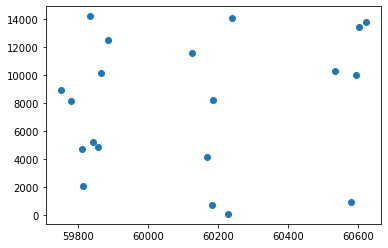

In [19]:
rank_w[-1]
tata = rank_to_object_id(-1, w_score, idx_id_w_dist)
mask_negative = lcs[tata] >= 0
plt.scatter(mjds[tata][mask_negative], lcs[tata][mask_negative])

Wasserstein vs Bottleneck

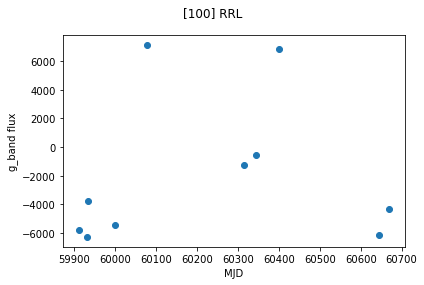

In [15]:
fig, ax = plt.subplots(tight_layout=True)

save_to = f"/home/edgar/astropology/img/mask_negative/{norm}"

if os.path.exists(save_to) is False:
    os.makedirs(f"{save_to}/bottleneck")
    os.makedirs(f"{save_to}/wasserstein")

for rank in range(1, 101):

    object_id = rank_to_object_id(-rank, b_score, idx_id_b_dist)
    target = meta_data.loc[object_id, "target"]
    ax.clear()

    fig.suptitle(f"[{rank}] {CLASSES[target]}")
    ax.set_xlabel("MJD")
    ax.set_ylabel(f"{band} flux")


    ax.scatter(mjds[object_id], lcs[object_id])
    
    fig.savefig(f"{save_to}/bottleneck/{rank:03d}_bottleneck_{norm}_{band}.pdf")

for rank in range(1, 101):

    object_id = rank_to_object_id(-rank, w_score, idx_id_w_dist)
    target = meta_data.loc[object_id, "target"]
    ax.clear()

    fig.suptitle(f"[{rank}] {CLASSES[target]}")
    ax.set_xlabel("MJD")
    ax.set_ylabel(f"{band} flux")
    ax.scatter(mjds[object_id], lcs[object_id])
    fig.savefig(f"{save_to}/wasserstein/{rank:03d}_wasserstein_{norm}_{band}.pdf")